# Supervised Learning

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
import imblearn

In [2]:
data = pd.read_csv('Travel.csv')
data.head()

,CustomerID,ProdTaken,Age,TypeofContact,CityTier,DurationOfPitch,Occupation,Gender,NumberOfPersonVisiting,NumberOfFollowups,ProductPitched,PreferredPropertyStar,MaritalStatus,NumberOfTrips,Passport,PitchSatisfactionScore,OwnCar,NumberOfChildrenVisiting,Designation,MonthlyIncome
0,200000,1,41.0,Self Enquiry,3,6.0,Salaried,Female,3,3.0,Deluxe,3.0,Single,1.0,1,2,1,0.0,Manager,20993.0
1,200001,0,49.0,Company Invited,1,14.0,Salaried,Male,3,4.0,Deluxe,4.0,Divorced,2.0,0,3,1,2.0,Manager,20130.0
2,200002,1,37.0,Self Enquiry,1,8.0,Free Lancer,Male,3,4.0,Basic,3.0,Single,7.0,1,3,0,0.0,Executive,17090.0
3,200003,0,33.0,Company Invited,1,9.0,Salaried,Female,2,3.0,Basic,3.0,Divorced,2.0,1,5,1,1.0,Executive,17909.0
4,200004,0,NaN,Self Enquiry,1,8.0,Small Business,Male,2,3.0,Basic,4.0,Divorced,1.0,0,5,1,0.0,Executive,18468.0


## Splitting Data

In [3]:
from sklearn.model_selection import train_test_split
X = data.drop('ProdTaken', axis=1)
y = data['ProdTaken']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify=y, random_state=42)

In [4]:
train =  pd.concat([X_train, pd.DataFrame(y_train)], axis=1)
test =  pd.concat([X_test, pd.DataFrame(y_test)], axis=1)

train.shape, test.shape

((3910, 20), (978, 20))

## Preprocessing Data

In [5]:
import pickle
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from imblearn.over_sampling import SMOTE

class CustomeridDropper(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X.drop(['CustomerID'], axis=1)

class DuplicatedDropper(BaseEstimator, TransformerMixin):
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X = X.drop_duplicates(keep='first')
        return X

class MissingImputer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        for i in (X.select_dtypes(include = 'number').columns):
            imputer = SimpleImputer(strategy='median')
            X[i] = imputer.fit_transform(X[[i]])
    
        for i in (X.select_dtypes(include = ['object','category']).columns):
            imputer = SimpleImputer(strategy='most_frequent')
            X[i] = imputer.fit_transform(X[[i]])
    
        return X

class ExtractAgeStructure(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X['AgeStructure'] = pd.cut(X['Age'], [15,24,54,64], labels=['Early Working Age','Prime Working Age', 'Mature Working Age'])
        return X

class DeleteOutliers(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):        
        X.loc[X['DurationOfPitch'] > 36.0, 'DurationOfPitch'] = 36.0
        X.loc[X['NumberOfPersonVisiting'] > 5, 'NumberOfPersonVisiting'] = 5
        X.loc[X['NumberOfFollowups'] > 6, 'NumberOfFollowups'] = 6
        X.loc[X['NumberOfTrips'] > 22.0 , 'NumberOfTrips'] = 22.0
        X.loc[X['MonthlyIncome'] > 38677.0, 'MonthlyIncome'] = 38677.0
        return X

class NumericTransformation(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
  
    def transform(self, X):
        nums = ['Age', 'DurationOfPitch', 'NumberOfPersonVisiting', 'NumberOfFollowups','NumberOfTrips', 'NumberOfChildrenVisiting', 'MonthlyIncome']
        for i in nums:
            scaler = StandardScaler()
            X[i]= scaler.fit_transform(X[i].values.reshape(len(X), 1))
        
        return X

class FeatureEncoder(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
  
    def transform(self, X):
        typeofcontact_dict = {'Self Enquiry' : 0, 'Company Invited' : 1}
        X['TypeofContact'] = [typeofcontact_dict[i] for i in X['TypeofContact']]

        X.loc[X['Gender'] == 'Fe Male', 'Gender'] = 'Female'
        gender_dict = {'Male' : 0, 'Female' : 1}
        X['Gender'] = [gender_dict[i] for i in X['Gender']]

        X.loc[X['MaritalStatus'] == 'Unmarried', 'MaritalStatus'] = 'Single'

        encoder = OneHotEncoder()
        categorical_cols = ['Occupation', 'ProductPitched', 'MaritalStatus','Designation','AgeStructure']
        for i in categorical_cols:
            matrix = encoder.fit_transform(X[[i]]).toarray()
            column_names = X[i].unique().tolist()
            for j in range(len(matrix.T)):
                X[column_names[j]] = matrix.T[j]
            X.drop([i], axis=1, inplace=True)
        
        return X

class BalancingClass(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
  
    def transform(self, X):
        y = X['ProdTaken'].values
        column_names = X.drop(['ProdTaken'], axis=1).columns.tolist()
        X = X.drop(['ProdTaken'], axis=1).values

        smote = SMOTE(sampling_strategy=1,random_state = 42)
        X, y = smote.fit_resample(X, y)

        X = pd.DataFrame(X, columns=column_names)
        y = pd.DataFrame(y, columns=['ProdTaken'])

        X = pd.concat([y, X], axis=1)
        
        return X

class ColumnsDropper(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
  
    def transform(self, X):
        significant_features = ['ProdTaken','Passport', 'Deluxe', 'Executive', 'Divorced', 'Basic', 'AVP', 'Age', 'Prime Working Age',
                      'MonthlyIncome', 'NumberOfFollowups', 'Single', 'Mature Working Age', 'King', 'Manager',
                      'PreferredPropertyStar', 'Married', 'CityTier', 'Super Deluxe', 'VP', 'DurationOfPitch',
                      'Salaried', 'PitchSatisfactionScore', 'Large Business', 'Gender', 'Small Business', 'TypeofContact',
                      'NumberOfTrips']
        X.drop(columns=([col for col in X.columns.tolist() if col not in significant_features]), axis=1, inplace=True)
        return X

with open('preprocessing_pipe.pkl', 'rb') as f:
    preprocessing_pipe = pickle.load(f)

In [6]:
train = preprocessing_pipe.fit_transform(train)
test = preprocessing_pipe.transform(test)

test = test[train.columns.tolist()]

train.shape, test.shape

((6186, 28), (1584, 28))

## Modeling

In [7]:
y_train = train.ProdTaken
X_train = train.drop(['ProdTaken'], axis= 1)

y_test = test.ProdTaken
X_test = test.drop(['ProdTaken'], axis= 1)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((6186, 27), (1584, 27), (6186,), (1584,))

In [8]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, auc

def eval_classification(model, pred, xtrain, ytrain, xtest, ytest):
    print("Accuracy (Train Set): %.2f" % model.score(xtrain, ytrain))
    print("Accuracy (Test Set): %.2f" % accuracy_score(ytest, pred))
    print("\nPrecision (Test Set): %.2f" % precision_score(ytest, pred))
    print("Recall (Test Set): %.2f" % recall_score(ytest, pred))
    print("F1-Score (Test Set): %.2f" % f1_score(ytest, pred))
    
    fpr, tpr, thresholds = roc_curve(ytest, pred, pos_label=1)
    print("AUC: %.2f" % auc(fpr, tpr))

### Random Forest

In [9]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

rf = RandomForestClassifier(max_features=5, n_estimators=100)
rf.fit(X_train, y_train)

RandomForestClassifier(max_features=5)

In [10]:
y_pred = rf.predict(X_test)
eval_classification(rf, y_pred, X_train, y_train, X_test, y_test)

Accuracy (Train Set): 1.00
Accuracy (Test Set): 0.74

Precision (Test Set): 0.92
Recall (Test Set): 0.53
F1-Score (Test Set): 0.68
AUC: 0.74


#### Hyperparameter Tuning

In [11]:
from sklearn.model_selection import GridSearchCV
import numpy as np

max_features_range = np.arange(1,11,1)
n_estimators_range = np.arange(10,210,10)
param_grid = dict(max_features=max_features_range, n_estimators=n_estimators_range)

rf = RandomForestClassifier()

grid = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5)

In [12]:
model = grid.fit(X_train, y_train)

In [13]:
print("The best parameters are %s with a score of %0.2f"
      % (grid.best_params_, grid.best_score_))

The best parameters are {'max_features': 1, 'n_estimators': 180} with a score of 0.97


In [14]:
y_pred = model.predict(X_test)
eval_classification(model, y_pred, X_train, y_train, X_test, y_test)

Accuracy (Train Set): 1.00
Accuracy (Test Set): 0.73

Precision (Test Set): 0.91
Recall (Test Set): 0.51
F1-Score (Test Set): 0.65
AUC: 0.73


### XGBoost Classifier

In [17]:
from xgboost import XGBClassifier
model_xgb = XGBClassifier(objective='binary:logistic', seed=42)
model_xgb.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=42,
              reg_alpha=0, reg_lambda=1, ...)

In [18]:
y_pred = model_xgb.predict(X_test)
eval_classification(model, y_pred, X_train, y_train, X_test, y_test)

Accuracy (Train Set): 1.00
Accuracy (Test Set): 0.75

Precision (Test Set): 0.70
Recall (Test Set): 0.87
F1-Score (Test Set): 0.78
AUC: 0.75


#### Hyperparameter Tuning

In [19]:
model_xgb = XGBClassifier(objective='binary:logistic',
                            gamma=0.25, 
                            learning_rate=0.1,
                            max_depth=14,
                            seed=42,
                            reg_lambda=0,
                            min_child_weight=1,
                            scale_pos_weight=3,
                            subsample=0.9,
                            colsample_bytree=0.5)

model_xgb.fit(X_train,
            y_train,
            verbose=False,
            early_stopping_rounds=10,
            eval_metric='aucpr',
            eval_set=[(X_test, y_test)])

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.5,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0.25, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=14, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=42,
              reg_alpha=0, reg_lambda=0, ...)

In [20]:
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import plot_confusion_matrix

print('Accuracy of XGB classifier on training set: {:.2f}'
       .format(model_xgb.score(X_train, y_train)))
print('Accuracy of XGB classifier on test set: {:.2f}'
       .format(model_xgb.score(X_test[X_train.columns], y_test)))

y_pred = model_xgb.predict(X_test)
print(classification_report(y_test, y_pred))

Accuracy of XGB classifier on training set: 1.00
Accuracy of XGB classifier on test set: 0.83
              precision    recall  f1-score   support

         0.0       0.79      0.89      0.84       792
         1.0       0.87      0.77      0.82       792

    accuracy                           0.83      1584
   macro avg       0.83      0.83      0.83      1584
weighted avg       0.83      0.83      0.83      1584



In [21]:
eval_classification(model_xgb, y_pred, X_train, y_train, X_test, y_test)

Accuracy (Train Set): 1.00
Accuracy (Test Set): 0.83

Precision (Test Set): 0.87
Recall (Test Set): 0.77
F1-Score (Test Set): 0.82
AUC: 0.83


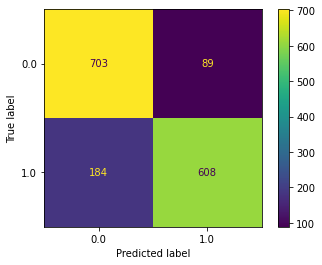

In [22]:
plot_confusion_matrix(model_xgb,
                     X_test,
                     y_test,
                     values_format='d') #display_labels=["Not Taken", "Taken"]

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

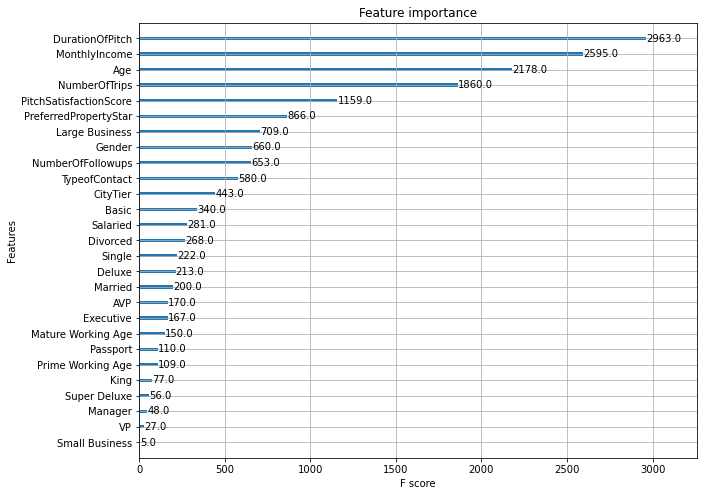

In [23]:
from xgboost import plot_importance
fig, ax = plt.subplots(figsize=(10,8))
plot_importance(model_xgb, ax=ax)

### Decision Tree

In [32]:
from sklearn.tree import DecisionTreeClassifier

model_DeciTr=DecisionTreeClassifier()
model_DeciTr.fit(X_train,y_train)
Y_pred= model_DeciTr.predict(X_test)
eval_classification(model, y_pred, X_train, y_train, X_test, y_test)
# DeciTr_acc=accuracy_score(Y_test,Y_pred)*100

Accuracy (Train Set): 1.00
Accuracy (Test Set): 0.83

Precision (Test Set): 0.87
Recall (Test Set): 0.77
F1-Score (Test Set): 0.82
AUC: 0.83


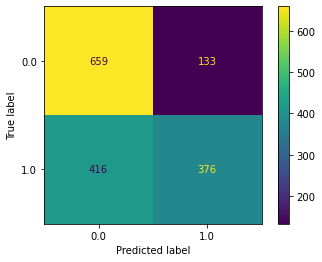

In [43]:
plot_confusion_matrix(model_DeciTr,
                     X_test,
                     y_test,
                     values_format='d') #display_labels=["Not Taken", "Taken"]

### Support Vector Machine (SVM)

In [48]:
from sklearn.svm import SVC

model_svm=SVC(kernel="poly")  #alternatif lain kernel= "linear" or "rbf"
model_svm.fit(X_train,y_train)
Y_pred= model_svm.predict(X_test)
eval_classification(model_svm, y_pred, X_train, y_train, X_test, y_test)
# SVC_acc=accuracy_score(y_test,Y_pred)*100

Accuracy (Train Set): 0.84
Accuracy (Test Set): 0.83

Precision (Test Set): 0.87
Recall (Test Set): 0.77
F1-Score (Test Set): 0.82
AUC: 0.83


### KNN (K-Nearest Neighbor)

In [36]:
#KNN
from sklearn.neighbors import KNeighborsClassifier
model_knn=KNeighborsClassifier(n_neighbors=3)
model_knn.fit(X_train,y_train)
Y_pred=model_knn.predict(X_test)
eval_classification(model_knn, y_pred, X_train, y_train, X_test, y_test)
# KNN_acc=accuracy_score(Y_test,Y_pred)*100

Accuracy (Train Set): 0.98
Accuracy (Test Set): 0.83

Precision (Test Set): 0.87
Recall (Test Set): 0.77
F1-Score (Test Set): 0.82
AUC: 0.83


### Naive Bayes

In [ ]:
#Naive Bayes
from sklearn.naive_bayes import GaussianNB

model_naive_bayes = GaussianNB()
model_naive_bayes.fit(X_train, y_train)
y_pred = model_naive_bayes.predict(X_test)
eval_classification(model_naive_bayes, y_pred, X_train, y_train, X_test, y_test)
